In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.sample import sample_gen
import rasterio.plot

from shapely.geometry import Point, box, Polygon

from sklearn.svm import OneClassSVM, SVC
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb


from skimage.transform import resize


In [101]:

# Add persence point file file path
pfile = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/strawb_points.csv'

#creates a pandas df
def create_df(file):
    df = pd.read_csv(file)
    return df

presences = create_df(pfile)

In [102]:
presences

,Species,Longitude,Latitude
0,221,-121.730795,41.829775
1,221,-122.345282,41.689828
2,221,-120.429168,41.572345
3,221,-121.114908,41.130171
4,221,-121.045248,41.139732
...,...,...,...
535,221,-118.015320,33.861685
536,221,-118.389675,33.752512
537,221,-118.020359,33.799740
538,221,-117.780775,33.674746


In [103]:
# presences.drop(columns=['pointid'], inplace=True)

In [104]:
presences.rename(columns={'SPECIES':'Species','LONGITUDE':'Longitude','LATITUDE':'Latitude'}, inplace=True)

In [105]:
def clip_raster_to_california(raster_path, output_path, california_boundary):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, [california_boundary], crop=True)
        out_meta = src.meta.copy()

        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


In [106]:
california_counties = gpd.read_file('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/California_County_Boundaries.geojson')
california_boundary = california_counties.unary_union

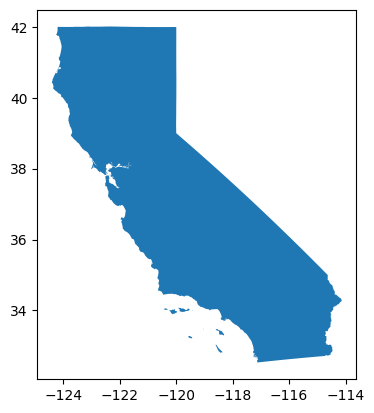

In [107]:
california_boundary_gdf = gpd.GeoDataFrame(geometry=[california_boundary], crs=california_counties.crs)

# Plotting
california_boundary_gdf.plot()
plt.show()

In [108]:
print(california_counties.crs)

EPSG:4326


### Generating dummy lat long values - Testing

In [109]:

def generate_random_coordinates(bounds, num_samples):
    min_lon, min_lat, max_lon, max_lat = bounds
    latitudes = [random.uniform(min_lat, max_lat) for _ in range(num_samples)]
    longitudes = [random.uniform(min_lon, max_lon) for _ in range(num_samples)]
    return latitudes, longitudes

# Bounds for California (min_longitude, min_latitude, max_longitude, max_latitude)
bounds = (-124.409591, 32.534156, -114.131211, 42.009518)

# Number of samples to generate
num_samples = 1000

# Generating random coordinates
latitudes, longitudes = generate_random_coordinates(bounds, num_samples)

# DataFrame to store 
df = pd.DataFrame({
    'Longitude': longitudes,
    'Latitude': latitudes
})

df


,Longitude,Latitude
0,-123.511872,41.756488
1,-120.061888,35.465714
2,-119.022484,41.797252
3,-120.067867,40.497897
4,-115.202657,34.742807
...,...,...
995,-117.081184,41.398244
996,-123.082202,39.237723
997,-118.240150,34.650398
998,-119.395285,36.425442


# **Implemenation Start**

# `Incorporating Presence Points with Bioclimatic Data`

In [110]:
def sample_raster_values(raster_path, presence_points):
    """
    Samples raster values at each coordinate in a Pandas dataframe.
    
    Parameters:
    -----------
    raster_path : str
        The path to the raster file.
    presence_points : pandas.DataFrame
        A Pandas dataframe with columns 'Longitude' and 'Latitude' containing the coordinates to sample.
        
    Returns:
    --------
    pandas.DataFrame
        A new Pandas dataframe with columns for each raster band containing the sampled values.
    """
    # Create an empty dataframe with the same index as presence_points
    bio_df = pd.DataFrame(index=presence_points.index)

    # Loop over each raster file
    for i in range(1, 20):
        filename = f'{raster_path}/bio_{i}.tif'

        # Open the raster file
        with rasterio.open(filename) as src:

            # Sample the raster at each coordinate in the dataframe
            values = []
            for idx, row in presence_points.iterrows():
                lon, lat = row['Longitude'], row['Latitude']
                result = list(src.sample([(lon, lat)]))

                # Extract the first and only value from the result if it's not None
                if result[0] is not None:
                    # Assuming result[0] is a one-element array, access the first element before converting
                    values.append(int(result[0][0]))  # Accessing the first element of the array
                else:
                    values.append('NA')


            # Add the values to the dataframe
            bio_df[f'bio_{i}'] = values
    
    return bio_df


In [111]:
bio_df = pd.DataFrame(columns=['bio_'+str(i) for i in range(1,20)]) #bio1-19
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/bioclims/californiaclipped'

In [112]:
# Empty df to store bio climatic variables
bio_df

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19


In [113]:
presence_bio_df = sample_raster_values(raster_path, presences)

In [114]:
presence_bio_df

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [115]:
presence_bio_df = pd.concat([presences,presence_bio_df],axis=1) #pp+bio

In [116]:
presence_bio_df

,Species,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,221,-121.730795,41.829775,91,119,35,7289,292,-43,335,...,203,0,350,49,7,45,143,30,30,136
1,221,-122.345282,41.689828,113,121,36,7102,309,-21,330,...,220,23,538,88,9,61,256,34,34,254
2,221,-120.429168,41.572345,95,116,33,7895,302,-48,350,...,216,-4,399,56,7,48,163,28,28,162
3,221,-121.114908,41.130171,103,120,34,7682,307,-40,347,...,219,5,413,62,5,55,185,20,20,185
4,221,-121.045248,41.139732,102,120,34,7698,307,-41,348,...,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,221,-118.015320,33.861685,196,106,43,4728,327,83,244,...,265,135,343,79,0,97,221,1,2,207
536,221,-118.389675,33.752512,174,90,44,3943,285,80,205,...,232,124,389,86,0,96,254,3,4,228
537,221,-118.020359,33.799740,195,103,43,4603,323,85,238,...,262,136,331,76,0,97,214,1,2,199
538,221,-117.780775,33.674746,192,101,43,4559,319,84,234,...,260,134,294,61,0,92,181,2,4,162


In [117]:
presence_bio_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/straw_pres_bio_df.csv',index=False)

# `OCSVM - Pseudoabsence data generation `

In [118]:
import numpy as np

# Assuming -3.4e38 is the NoData value
no_data_value = -339999995214436424907732413799364296704
presence_bio_df.replace(no_data_value, np.nan, inplace=True)

In [119]:
presence_bio_df.dropna(inplace=True)

In [120]:
presence_bio_df.iloc[:, 3:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [121]:
# Normalize the data to feed ocsvm
X = presence_bio_df.iloc[:,3:].values

# Standardize the bioclimatic data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [122]:
nu_s=[0.01,0.05,0.1,0.5] #hyperparameter

# Train OCSVM model using presence data nu=0.01
ocsvm_m1 = OneClassSVM(nu=nu_s[0])
ocsvm_m1.fit(X)

# Train OCSVM model using presence data nu=0.05
ocsvm_m2 = OneClassSVM(nu=nu_s[1])
ocsvm_m2.fit(X)

# Train OCSVM model using presence data nu=0.1
ocsvm_m3 = OneClassSVM(nu=nu_s[2])
ocsvm_m3.fit(X)


ocsvm_m4 = OneClassSVM(nu=nu_s[3])
ocsvm_m4.fit(X)

OneClassSVM()

In [123]:
def generate_pseudoabsences(polygon, n_pseudoabsences):
    """
    Generates pseudoabsence points within a polygon.
    
    Parameters:
    -----------
    polygon : shapely.geometry.Polygon
        The polygon in which to generate the pseudoabsences.
    n_pseudoabsences : int
        The number of pseudoabsences to generate.
        
    Returns:
    --------
    list
        A list of tuples, where each tuple contains the x and y coordinates of a pseudoabsence point.
    """
    # Define the extent of the polygon
    min_x, min_y, max_x, max_y = polygon.bounds

    # Generate the pseudoabsences
    pseudoabsences = []
    while len(pseudoabsences) < n_pseudoabsences:
        # Generate a random point within the extent of the polygon
        x = random.uniform(min_x, max_x)
        y = random.uniform(min_y, max_y)
        point = Point(x, y)

        # Check if the point is within the polygon
        if polygon.contains(point):
            pseudoabsences.append((x, y))
    
    return pseudoabsences

In [124]:
# Bounding box coordinates for entire California
min_lon, min_lat = -124.409591, 32.534156
max_lon, max_lat = -114.131211, 42.009518

# Created a polygon using the bounding box coordinates
cali_sm2_loc = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])

pseudoabsences = generate_pseudoabsences(cali_sm2_loc,n_pseudoabsences=2000)

In [194]:
# pseudoabsences

In [126]:
# Created a df containing pseudoabs+biovars
pseudoabsences_df = pd.DataFrame({'Longitude': [x[0] for x in pseudoabsences],
                                  'Latitude': [x[1] for x in pseudoabsences]})


In [127]:
pseudoabsences_df

,Longitude,Latitude
0,-118.552055,39.301520
1,-119.778369,39.424032
2,-118.735092,36.996795
3,-122.543599,38.482597
4,-116.022177,36.830672
...,...,...
1995,-117.336602,41.285178
1996,-123.755994,36.978154
1997,-121.972445,40.910242
1998,-122.635694,34.254163


In [128]:
# Incorporating background points with bio climatic raster data 
pseudoabsences_bio_df=sample_raster_values(raster_path,pseudoabsences_df)
pseudoabsences_bio_df=pd.concat([pseudoabsences_df,pseudoabsences_bio_df],axis=1)

In [129]:
pseudoabsences_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-118.552055,39.301520,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1,-119.778369,39.424032,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
2,-118.735092,36.996795,35,119,37,6914,213,-105,319,-44,...,137,-52,664,123,8,76,366,26,26,336
3,-122.543599,38.482597,131,101,43,4485,263,27,235,68,...,191,68,982,207,1,90,591,7,7,591
4,-116.022177,36.830672,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-117.336602,41.285178,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1996,-123.755994,36.978154,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1997,-121.972445,40.910242,134,122,35,7549,336,-8,345,38,...,247,38,1424,275,4,80,791,30,30,791
1998,-122.635694,34.254163,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535


In [130]:
# pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-339999995214436424907732413799364296704),np.nan)

pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-32768, 65535),np.nan)

pseudoabsences_bio_df=pseudoabsences_bio_df.dropna()

pseudoabsences_bio_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
2,-118.735092,36.996795,35.0,119,37,6914.0,213.0,-105.0,319.0,-44.0,...,137.0,-52.0,664.0,123.0,8.0,76.0,366.0,26.0,26.0,336.0
3,-122.543599,38.482597,131.0,101,43,4485.0,263.0,27.0,235.0,68.0,...,191.0,68.0,982.0,207.0,1.0,90.0,591.0,7.0,7.0,591.0
5,-116.261460,34.132579,188.0,134,39,7157.0,373.0,32.0,340.0,93.0,...,291.0,93.0,103.0,19.0,0.0,61.0,52.0,2.0,22.0,52.0
6,-117.862922,34.943337,182.0,129,38,7109.0,365.0,32.0,333.0,100.0,...,284.0,90.0,119.0,23.0,1.0,79.0,67.0,4.0,10.0,63.0
9,-118.698289,36.321839,66.0,122,38,6789.0,244.0,-73.0,317.0,-6.0,...,166.0,-19.0,834.0,151.0,2.0,83.0,447.0,10.0,10.0,419.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,-119.522807,36.653745,193.0,128,39,6593.0,374.0,53.0,321.0,112.0,...,290.0,109.0,330.0,64.0,0.0,85.0,181.0,0.0,0.0,181.0
1982,-122.283107,38.415241,140.0,108,43,4688.0,279.0,31.0,248.0,78.0,...,203.0,74.0,790.0,163.0,1.0,88.0,461.0,7.0,7.0,460.0
1985,-117.906766,34.974981,180.0,129,38,7130.0,364.0,30.0,333.0,98.0,...,283.0,88.0,122.0,24.0,1.0,80.0,69.0,4.0,10.0,65.0
1988,-116.208438,34.455367,190.0,133,37,7511.0,379.0,29.0,349.0,90.0,...,297.0,90.0,103.0,15.0,0.0,51.0,43.0,3.0,34.0,43.0


In [131]:
# Extract only bioclimatic data for the presence points
x = pseudoabsences_bio_df.iloc[:, 2:].values

# Standardize the bioclimatic data
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [132]:
# suitable points (1) unsuitable (-1)
pseudo_absences_m1 = pseudoabsences_bio_df.loc[ocsvm_m1.predict(x) == -1] #0.01

pseudo_absences_m2 = pseudoabsences_bio_df.loc[ocsvm_m2.predict(x) == -1] #0.05

pseudo_absences_m3 = pseudoabsences_bio_df.loc[ocsvm_m3.predict(x) == -1] #0.1

pseudo_absences_m4 = pseudoabsences_bio_df.loc[ocsvm_m4.predict(x) == -1] #0.1

In [133]:
# print("Unsuitable points detected with ocsvm model 1 with nu = 0.01 :", pseudo_absences_m1.shape[0])
# print("Unsuitable points detected with ocsvm model 2 with nu = 0.05 :", pseudo_absences_m2.shape[0])
print("Unsuitable points detected with ocsvm model 3 with nu = 0.1 :", pseudo_absences_m3.shape[0])
print("Unsuitable points detected with ocsvm model 4 with nu = 0.5 :", pseudo_absences_m4.shape[0])

Unsuitable points detected with ocsvm model 3 with nu = 0.1 : 720
Unsuitable points detected with ocsvm model 4 with nu = 0.5 : 873


In [134]:
pseudo_absences_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/unsuitable_ocsvm_m3_str.csv',index=False)
pseudo_absences_m4.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/unsuitable_ocsvm_m4_str.csv',index=False)

In [135]:
# suitable points (1) unsuitable (-1)
suitable_m1 = pseudoabsences_bio_df.loc[ocsvm_m1.predict(x) == 1]
suitable_m2 = pseudoabsences_bio_df.loc[ocsvm_m2.predict(x) == 1]
suitable_m3 = pseudoabsences_bio_df.loc[ocsvm_m3.predict(x) == 1]

print("Suitable points detected with ocsvm model 1 with nu = 0.01 :", suitable_m1.shape[0])
print("Suitable points detected with ocsvm model 2 with nu = 0.05 :", suitable_m2.shape[0])
print("Suitable points detected with ocsvm model 3 with nu = 0.1 :", suitable_m3.shape[0])

Suitable points detected with ocsvm model 1 with nu = 0.01 : 451
Suitable points detected with ocsvm model 2 with nu = 0.05 : 383
Suitable points detected with ocsvm model 3 with nu = 0.1 : 153


In [136]:
suitable_m3.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/suitable_ocsvm_m3_str.csv',index=False)

***

# `New Pseudoabsence Generation Method`

In [137]:
# Load bioclimatic variables data
bioclim_data = []
for i in range(1, 20):
    file_name = "/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/bioclims/californiaclipped/bio_" + str(i) + ".tif"
    with rasterio.open(file_name) as src:
        data = src.read(1).astype(np.float32)
        # Mask out nodata values
        data = np.ma.masked_equal(data, src.nodata)
        bioclim_data.append(data)

env_data = np.stack(bioclim_data, axis=2)

In [138]:
def generate_target_background(presence_points_df, study_area, n_samples=1000):
    # Presence points are in GeoDataFrame format
    if not isinstance(presence_points_df, gpd.GeoDataFrame):
        # Converting to GeoDataFrame assuming 'Longitude' and 'Latitude' columns
        presence_points_df = gpd.GeoDataFrame(
            presence_points_df, 
            geometry=gpd.points_from_xy(presence_points_df.Longitude, presence_points_df.Latitude)
        )

    background_points = []
    minx, miny, maxx, maxy = study_area.bounds  # Unpacking the bounds directly

    while len(background_points) < n_samples:
        # Randomly generated a point within the extent of the study area
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)

        # Ensured the point is not in any presence points and is within the study area
        if study_area.contains(point) and not presence_points_df.contains(point).any():
            background_points.append((x, y))

    # Convert -> DataFrame -> GeoDataFrame
    background_points_df = pd.DataFrame(background_points, columns=['Longitude', 'Latitude'])
    return gpd.GeoDataFrame(background_points_df, geometry=gpd.points_from_xy(background_points_df.Longitude, background_points_df.Latitude))

# Defined the bounding box coordinates for California
california_bounds = (-124.409591, 32.534156, -114.131211, 42.009518)
california_polygon = Polygon([(california_bounds[0], california_bounds[1]), 
                              (california_bounds[0], california_bounds[3]), 
                              (california_bounds[2], california_bounds[3]), 
                              (california_bounds[2], california_bounds[1])])

# Generate background points
background_points = generate_target_background(presences, california_polygon, n_samples=2000)


In [139]:
background_points

,Longitude,Latitude,geometry
0,-123.013587,38.714587,POINT (-123.01359 38.71459)
1,-117.322505,33.571945,POINT (-117.32250 33.57194)
2,-123.394821,41.934988,POINT (-123.39482 41.93499)
3,-114.430530,37.093266,POINT (-114.43053 37.09327)
4,-115.768693,36.129904,POINT (-115.76869 36.12990)
...,...,...,...
1995,-120.147859,37.161876,POINT (-120.14786 37.16188)
1996,-120.332076,33.752721,POINT (-120.33208 33.75272)
1997,-123.322937,40.768363,POINT (-123.32294 40.76836)
1998,-124.180111,40.399696,POINT (-124.18011 40.39970)


In [140]:
raster_path = '/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/bioclims/californiaclipped'

In [141]:
pseudoabsences_bio_df2=sample_raster_values(raster_path,background_points[['Longitude','Latitude']])
pseudoabsences_bio_df2

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,142,89,42,4155,261,48,212,85,194,198,85,1097,260,1,94,733,9,11,733
1,159,111,43,4929,298,43,254,102,219,232,96,328,69,1,90,199,7,10,191
2,79,106,40,5442,237,-27,265,11,150,161,11,1697,346,6,90,1030,25,33,1030
3,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
4,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,186,127,41,6121,361,52,309,108,274,274,106,361,65,1,83,192,3,3,192
1996,-32768,255,127,65535,-32768,-32768,65535,-32768,-32768,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1997,121,112,39,5846,289,6,283,47,198,208,47,971,190,3,82,561,20,25,561
1998,101,60,40,3097,186,38,147,63,139,146,63,2047,372,3,81,1092,23,40,1092


In [142]:
pseudoabsences_bio_df2=pd.concat([background_points[['Longitude','Latitude']],pseudoabsences_bio_df2],axis=1)

In [143]:
pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-123.013587,38.714587,142,89,42,4155,261,48,212,85,...,198,85,1097,260,1,94,733,9,11,733
1,-117.322505,33.571945,159,111,43,4929,298,43,254,102,...,232,96,328,69,1,90,199,7,10,191
2,-123.394821,41.934988,79,106,40,5442,237,-27,265,11,...,161,11,1697,346,6,90,1030,25,33,1030
3,-114.430530,37.093266,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
4,-115.768693,36.129904,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-120.147859,37.161876,186,127,41,6121,361,52,309,108,...,274,106,361,65,1,83,192,3,3,192
1996,-120.332076,33.752721,-32768,255,127,65535,-32768,-32768,65535,-32768,...,-32768,-32768,65535,65535,65535,65535,65535,65535,65535,65535
1997,-123.322937,40.768363,121,112,39,5846,289,6,283,47,...,208,47,971,190,3,82,561,20,25,561
1998,-124.180111,40.399696,101,60,40,3097,186,38,147,63,...,146,63,2047,372,3,81,1092,23,40,1092


In [144]:
# pseudoabsences_bio_df=pseudoabsences_bio_df.replace((-339999995214436424907732413799364296704),np.nan)

pseudoabsences_bio_df2=pseudoabsences_bio_df2.replace((-32768, 65535),np.nan)

pseudoabsences_bio_df2=pseudoabsences_bio_df2.dropna()

pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-123.013587,38.714587,142.0,89,42,4155.0,261.0,48.0,212.0,85.0,...,198.0,85.0,1097.0,260.0,1.0,94.0,733.0,9.0,11.0,733.0
1,-117.322505,33.571945,159.0,111,43,4929.0,298.0,43.0,254.0,102.0,...,232.0,96.0,328.0,69.0,1.0,90.0,199.0,7.0,10.0,191.0
2,-123.394821,41.934988,79.0,106,40,5442.0,237.0,-27.0,265.0,11.0,...,161.0,11.0,1697.0,346.0,6.0,90.0,1030.0,25.0,33.0,1030.0
8,-119.784549,34.971990,152.0,121,44,5142.0,302.0,29.0,273.0,93.0,...,226.0,85.0,238.0,47.0,1.0,87.0,141.0,3.0,4.0,122.0
10,-119.663364,35.615191,192.0,132,42,6118.0,366.0,52.0,313.0,123.0,...,281.0,113.0,141.0,28.0,0.0,85.0,85.0,1.0,2.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,-116.085430,32.728176,197.0,134,43,5953.0,365.0,59.0,305.0,120.0,...,284.0,120.0,168.0,34.0,1.0,70.0,92.0,5.0,28.0,92.0
1993,-117.935834,36.992685,124.0,115,32,8181.0,315.0,-35.0,351.0,29.0,...,242.0,17.0,132.0,22.0,4.0,52.0,65.0,15.0,21.0,59.0
1995,-120.147859,37.161876,186.0,127,41,6121.0,361.0,52.0,309.0,108.0,...,274.0,106.0,361.0,65.0,1.0,83.0,192.0,3.0,3.0,192.0
1997,-123.322937,40.768363,121.0,112,39,5846.0,289.0,6.0,283.0,47.0,...,208.0,47.0,971.0,190.0,3.0,82.0,561.0,20.0,25.0,561.0


In [145]:
def extract_environmental_variables(points, env_data, affine_transform):
    variables = []
    for point in points:
        # Point is a Shapely Point or a tuple of coordinates (x, y)
        if isinstance(point, tuple):
            x, y = point
        elif isinstance(point, Point):
            x, y = point.x, point.y
        else:
            raise ValueError("Point is neither a tuple nor a shapely Point.")
        
        # Converted geographic coordinates to pixel coordinates
        row, col = ~affine_transform * (x, y)
        row, col = int(row), int(col)  # Convert to integer for indexing

        # Extracted the data for all layers at this point, ensuring we're within bounds
        if 0 <= row < env_data.shape[0] and 0 <= col < env_data.shape[1]:
            data = env_data[row, col, :]
            variables.append(data)
        else:
            # Handled cases where point is out of bounds
            variables.append([np.nan] * env_data.shape[2])  
    return np.array(variables)

In [146]:
# Converted DataFrame to list of tuples or Shapely Points
presence_tuples = list(zip(presences['Longitude'], presences['Latitude']))
presence_points = [Point(xy) for xy in zip(presences['Longitude'], presences['Latitude'])]

background_tuples = list(zip(background_points['Longitude'], background_points['Latitude']))
background_points = [Point(xy) for xy in zip(background_points['Longitude'], background_points['Latitude'])]

In [147]:
X_presence = extract_environmental_variables(presence_points, env_data, src.transform)
X_background = extract_environmental_variables(background_points, env_data, src.transform)

y_presence = [1] * len(X_presence)
y_background = [0] * len(X_background)

X = pd.concat([pd.DataFrame(X_presence), pd.DataFrame(X_background)])
y = y_presence + y_background

In [148]:
# presence_bio_df.drop(columns=['Species'],inplace=True)

In [149]:
presence_bio_df['presence']=1
pseudoabsences_bio_df2['presence']=0

In [150]:
presence_bio_df

,Species,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,221,-121.730795,41.829775,91,119,35,7289,292,-43,335,...,0,350,49,7,45,143,30,30,136,1
1,221,-122.345282,41.689828,113,121,36,7102,309,-21,330,...,23,538,88,9,61,256,34,34,254,1
2,221,-120.429168,41.572345,95,116,33,7895,302,-48,350,...,-4,399,56,7,48,163,28,28,162,1
3,221,-121.114908,41.130171,103,120,34,7682,307,-40,347,...,5,413,62,5,55,185,20,20,185,1
4,221,-121.045248,41.139732,102,120,34,7698,307,-41,348,...,5,388,55,5,51,164,21,21,164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,221,-118.015320,33.861685,196,106,43,4728,327,83,244,...,135,343,79,0,97,221,1,2,207,1
536,221,-118.389675,33.752512,174,90,44,3943,285,80,205,...,124,389,86,0,96,254,3,4,228,1
537,221,-118.020359,33.799740,195,103,43,4603,323,85,238,...,136,331,76,0,97,214,1,2,199,1
538,221,-117.780775,33.674746,192,101,43,4559,319,84,234,...,134,294,61,0,92,181,2,4,162,1


In [151]:
pseudoabsences_bio_df2

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-123.013587,38.714587,142.0,89,42,4155.0,261.0,48.0,212.0,85.0,...,85.0,1097.0,260.0,1.0,94.0,733.0,9.0,11.0,733.0,0
1,-117.322505,33.571945,159.0,111,43,4929.0,298.0,43.0,254.0,102.0,...,96.0,328.0,69.0,1.0,90.0,199.0,7.0,10.0,191.0,0
2,-123.394821,41.934988,79.0,106,40,5442.0,237.0,-27.0,265.0,11.0,...,11.0,1697.0,346.0,6.0,90.0,1030.0,25.0,33.0,1030.0,0
8,-119.784549,34.971990,152.0,121,44,5142.0,302.0,29.0,273.0,93.0,...,85.0,238.0,47.0,1.0,87.0,141.0,3.0,4.0,122.0,0
10,-119.663364,35.615191,192.0,132,42,6118.0,366.0,52.0,313.0,123.0,...,113.0,141.0,28.0,0.0,85.0,85.0,1.0,2.0,72.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,-116.085430,32.728176,197.0,134,43,5953.0,365.0,59.0,305.0,120.0,...,120.0,168.0,34.0,1.0,70.0,92.0,5.0,28.0,92.0,0
1993,-117.935834,36.992685,124.0,115,32,8181.0,315.0,-35.0,351.0,29.0,...,17.0,132.0,22.0,4.0,52.0,65.0,15.0,21.0,59.0,0
1995,-120.147859,37.161876,186.0,127,41,6121.0,361.0,52.0,309.0,108.0,...,106.0,361.0,65.0,1.0,83.0,192.0,3.0,3.0,192.0,0
1997,-123.322937,40.768363,121.0,112,39,5846.0,289.0,6.0,283.0,47.0,...,47.0,971.0,190.0,3.0,82.0,561.0,20.0,25.0,561.0,0


In [152]:
presence_bio_df.iloc[:,3:22].values

array([[ 91, 119,  35, ...,  30,  30, 136],
       [113, 121,  36, ...,  34,  34, 254],
       [ 95, 116,  33, ...,  28,  28, 162],
       ...,
       [195, 103,  43, ...,   1,   2, 199],
       [192, 101,  43, ...,   2,   4, 162],
       [181, 102,  43, ...,   4,   5, 174]])

In [153]:
presence_bio_df.iloc[:, 22].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [154]:
pre_pseu_df = pd.concat([presence_bio_df.drop(columns=['Species']), pseudoabsences_bio_df2])

In [155]:
pre_pseu_df

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,-116.085430,32.728176,197.0,134,43,5953.0,365.0,59.0,305.0,120.0,...,120.0,168.0,34.0,1.0,70.0,92.0,5.0,28.0,92.0,0
1993,-117.935834,36.992685,124.0,115,32,8181.0,315.0,-35.0,351.0,29.0,...,17.0,132.0,22.0,4.0,52.0,65.0,15.0,21.0,59.0,0
1995,-120.147859,37.161876,186.0,127,41,6121.0,361.0,52.0,309.0,108.0,...,106.0,361.0,65.0,1.0,83.0,192.0,3.0,3.0,192.0,0
1997,-123.322937,40.768363,121.0,112,39,5846.0,289.0,6.0,283.0,47.0,...,47.0,971.0,190.0,3.0,82.0,561.0,20.0,25.0,561.0,0


In [156]:
pre_pseu_df.reset_index(drop=True, inplace=True)

In [157]:
X = pre_pseu_df.iloc[:, :-1]
y = pre_pseu_df['presence']

In [158]:
pre_pseu_df.iloc[:, :-1]

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,203.0,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,220.0,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,216.0,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,219.0,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,219.0,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-116.085430,32.728176,197.0,134,43,5953.0,365.0,59.0,305.0,120.0,...,284.0,120.0,168.0,34.0,1.0,70.0,92.0,5.0,28.0,92.0
1436,-117.935834,36.992685,124.0,115,32,8181.0,315.0,-35.0,351.0,29.0,...,242.0,17.0,132.0,22.0,4.0,52.0,65.0,15.0,21.0,59.0
1437,-120.147859,37.161876,186.0,127,41,6121.0,361.0,52.0,309.0,108.0,...,274.0,106.0,361.0,65.0,1.0,83.0,192.0,3.0,3.0,192.0
1438,-123.322937,40.768363,121.0,112,39,5846.0,289.0,6.0,283.0,47.0,...,208.0,47.0,971.0,190.0,3.0,82.0,561.0,20.0,25.0,561.0


***

# `Isolation Forest - Pseudoabsence Generation` - New Method after OCSVM (Part of Implementation)

In [159]:
def generate_target_background(presence_points_df, study_area, n_samples=1000):
    # Presence points are in GeoDataFrame format
    if not isinstance(presence_points_df, gpd.GeoDataFrame):
        # Converting to GeoDataFrame assuming 'Longitude' and 'Latitude' columns
        presence_points_df = gpd.GeoDataFrame(
            presence_points_df, 
            geometry=gpd.points_from_xy(presence_points_df.Longitude, presence_points_df.Latitude)
        )

    background_points = []
    minx, miny, maxx, maxy = study_area.bounds  # Unpacking the bounds directly

    while len(background_points) < n_samples:
        # Randomly generated a point within the extent of the study area
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)

        # Ensured the point is not in any presence points and is within the study area
        if study_area.contains(point) and not presence_points_df.contains(point).any():
            background_points.append((x, y))

    # Convert -> DataFrame -> GeoDataFrame
    background_points_df = pd.DataFrame(background_points, columns=['Longitude', 'Latitude'])
    return gpd.GeoDataFrame(background_points_df, geometry=gpd.points_from_xy(background_points_df.Longitude, background_points_df.Latitude))

# Defined the bounding box coordinates for California
california_bounds = (-124.409591, 32.534156, -114.131211, 42.009518)
california_polygon = Polygon([(california_bounds[0], california_bounds[1]), 
                              (california_bounds[0], california_bounds[3]), 
                              (california_bounds[2], california_bounds[3]), 
                              (california_bounds[2], california_bounds[1])])

# Generate background points
background_points = generate_target_background(presences, california_polygon, n_samples=2000)


In [160]:
presence_bio_df.iloc[:, 3:22]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [161]:
background_points = generate_target_background(presences, california_polygon, n_samples=2000)

In [162]:
background_points

,Longitude,Latitude,geometry
0,-123.322145,35.000766,POINT (-123.32214 35.00077)
1,-118.664314,39.456153,POINT (-118.66431 39.45615)
2,-123.897906,34.882475,POINT (-123.89791 34.88247)
3,-122.518368,33.545480,POINT (-122.51837 33.54548)
4,-120.180175,41.431261,POINT (-120.18018 41.43126)
...,...,...,...
1995,-121.019577,36.258112,POINT (-121.01958 36.25811)
1996,-119.258356,41.633100,POINT (-119.25836 41.63310)
1997,-117.108479,35.813494,POINT (-117.10848 35.81349)
1998,-116.554341,33.316479,POINT (-116.55434 33.31648)


In [163]:
background_points.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/background_points.csv',index=False)

In [164]:
# (excluding 'Longitude' and 'Latitude' for the model features)
X = presence_bio_df.iloc[:, 3:22].values

# Initialized and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(X)


IsolationForest()

In [165]:
# Prepare the background data for prediction
background_data = sample_raster_values(raster_path, background_points)

In [166]:
background_data_df = pd.concat([background_points,background_data],axis=1)

In [167]:
background_data_df.shape

(2000, 22)

In [168]:
background_data_df=background_data_df.replace((-32768, 65535),np.nan)

background_data_df=background_data_df.dropna()

In [169]:
background_data_df.iloc[:, 3:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
4,76.0,115,32,7893.0,282.0,-68.0,350.0,-22.0,196.0,196.0,-24.0,311.0,39.0,6.0,42.0,117.0,23.0,23.0,117.0
9,72.0,123,35,7566.0,269.0,-79.0,349.0,-25.0,184.0,184.0,-25.0,419.0,82.0,8.0,70.0,233.0,25.0,25.0,233.0
10,140.0,105,47,3885.0,262.0,38.0,224.0,86.0,187.0,193.0,86.0,508.0,115.0,0.0,97.0,330.0,2.0,2.0,330.0
13,194.0,106,43,4694.0,325.0,83.0,242.0,140.0,251.0,263.0,134.0,358.0,83.0,0.0,98.0,235.0,1.0,4.0,218.0
16,177.0,124,42,5541.0,341.0,50.0,291.0,102.0,249.0,255.0,102.0,349.0,67.0,1.0,83.0,188.0,4.0,5.0,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,65.0,123,36,7085.0,254.0,-80.0,335.0,-25.0,169.0,169.0,-25.0,954.0,193.0,10.0,78.0,553.0,36.0,36.0,553.0
1995,153.0,122,46,4668.0,299.0,34.0,265.0,99.0,212.0,217.0,88.0,356.0,73.0,1.0,91.0,208.0,3.0,3.0,204.0
1997,184.0,122,33,8317.0,379.0,18.0,361.0,87.0,255.0,302.0,73.0,125.0,23.0,1.0,66.0,68.0,8.0,28.0,52.0
1998,107.0,130,44,5596.0,267.0,-24.0,292.0,44.0,144.0,189.0,35.0,472.0,85.0,2.0,74.0,243.0,16.0,48.0,237.0


In [170]:
background_data_df.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/background_data_df_str.csv',index=False)

In [171]:
background_data_values = background_data_df.iloc[:, 3:].values  # Assuming the first two columns are Long and Lat

In [172]:
# Predict pseudo-absences using the isolation forest model
background_predictions = iso_forest.predict(background_data_values)

In [173]:
# Filtered out the normal points, leaving only the anomalies as pseudo-absences
pseudo_absences_iso = background_data_df[background_predictions == -1]

In [174]:
pseudo_absences_iso

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
4,-120.180175,41.431261,POINT (-120.18018 41.43126),76.0,115,32,7893.0,282.0,-68.0,350.0,...,196.0,-24.0,311.0,39.0,6.0,42.0,117.0,23.0,23.0,117.0
9,-120.073448,39.583330,POINT (-120.07345 39.58333),72.0,123,35,7566.0,269.0,-79.0,349.0,...,184.0,-25.0,419.0,82.0,8.0,70.0,233.0,25.0,25.0,233.0
17,-116.696821,35.111882,POINT (-116.69682 35.11188),203.0,129,35,8027.0,398.0,36.0,361.0,...,316.0,95.0,125.0,19.0,2.0,50.0,54.0,7.0,37.0,45.0
22,-123.936930,41.754234,POINT (-123.93693 41.75423),104.0,79,40,4141.0,220.0,22.0,197.0,...,166.0,52.0,2173.0,390.0,8.0,77.0,1170.0,50.0,53.0,1170.0
24,-121.568082,37.533879,POINT (-121.56808 37.53388),108.0,110,46,4215.0,241.0,1.0,239.0,...,165.0,49.0,407.0,76.0,1.0,82.0,217.0,5.0,7.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,-117.631605,36.067333,POINT (-117.63160 36.06733),129.0,120,34,7908.0,319.0,-27.0,346.0,...,243.0,26.0,163.0,30.0,3.0,62.0,86.0,13.0,32.0,66.0
1988,-116.592596,36.175546,POINT (-116.59260 36.17555),170.0,120,32,8528.0,366.0,0.0,366.0,...,290.0,55.0,102.0,18.0,1.0,64.0,54.0,6.0,18.0,47.0
1991,-120.202249,39.168794,POINT (-120.20225 39.16879),65.0,123,36,7085.0,254.0,-80.0,335.0,...,169.0,-25.0,954.0,193.0,10.0,78.0,553.0,36.0,36.0,553.0
1997,-117.108479,35.813494,POINT (-117.10848 35.81349),184.0,122,33,8317.0,379.0,18.0,361.0,...,302.0,73.0,125.0,23.0,1.0,66.0,68.0,8.0,28.0,52.0


In [175]:
pseudo_absences_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/unsuitable_iso_unscaled_str.csv',index=False)

## `Using Scaling`

In [176]:
presence_bio_df.iloc[:, 3:22]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,91,119,35,7289,292,-43,335,10,203,203,0,350,49,7,45,143,30,30,136
1,113,121,36,7102,309,-21,330,30,220,220,23,538,88,9,61,256,34,34,254
2,95,116,33,7895,302,-48,350,6,216,216,-4,399,56,7,48,163,28,28,162
3,103,120,34,7682,307,-40,347,5,219,219,5,413,62,5,55,185,20,20,185
4,102,120,34,7698,307,-41,348,5,219,219,5,388,55,5,51,164,21,21,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,196,106,43,4728,327,83,244,142,253,265,135,343,79,0,97,221,1,2,207
536,174,90,44,3943,285,80,205,128,220,232,124,389,86,0,96,254,3,4,228
537,195,103,43,4603,323,85,238,142,250,262,136,331,76,0,97,214,1,2,199
538,192,101,43,4559,319,84,234,140,247,260,134,294,61,0,92,181,2,4,162


In [177]:
# normalized the data to feed Isoloation Forest 
X = presence_bio_df.iloc[:, 3:22].values

# Standardize the bioclimatic data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [178]:
X.shape

(540, 19)

In [179]:
# Initialized and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto')
iso_forest.fit(X)

IsolationForest()

In [180]:
background_data_df.iloc[:, 3:]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
4,76.0,115,32,7893.0,282.0,-68.0,350.0,-22.0,196.0,196.0,-24.0,311.0,39.0,6.0,42.0,117.0,23.0,23.0,117.0
9,72.0,123,35,7566.0,269.0,-79.0,349.0,-25.0,184.0,184.0,-25.0,419.0,82.0,8.0,70.0,233.0,25.0,25.0,233.0
10,140.0,105,47,3885.0,262.0,38.0,224.0,86.0,187.0,193.0,86.0,508.0,115.0,0.0,97.0,330.0,2.0,2.0,330.0
13,194.0,106,43,4694.0,325.0,83.0,242.0,140.0,251.0,263.0,134.0,358.0,83.0,0.0,98.0,235.0,1.0,4.0,218.0
16,177.0,124,42,5541.0,341.0,50.0,291.0,102.0,249.0,255.0,102.0,349.0,67.0,1.0,83.0,188.0,4.0,5.0,188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,65.0,123,36,7085.0,254.0,-80.0,335.0,-25.0,169.0,169.0,-25.0,954.0,193.0,10.0,78.0,553.0,36.0,36.0,553.0
1995,153.0,122,46,4668.0,299.0,34.0,265.0,99.0,212.0,217.0,88.0,356.0,73.0,1.0,91.0,208.0,3.0,3.0,204.0
1997,184.0,122,33,8317.0,379.0,18.0,361.0,87.0,255.0,302.0,73.0,125.0,23.0,1.0,66.0,68.0,8.0,28.0,52.0
1998,107.0,130,44,5596.0,267.0,-24.0,292.0,44.0,144.0,189.0,35.0,472.0,85.0,2.0,74.0,243.0,16.0,48.0,237.0


In [181]:
# Extracted the bioclimatic data for the pseudoabsence points
x = background_data_df.iloc[:, 3:].values

# Standardized the test bioclimatic data
x = scaler.transform(x)

In [182]:
background_data_iso = background_data_df.loc[iso_forest.predict(x) == -1]

In [183]:
background_data_iso

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
4,-120.180175,41.431261,POINT (-120.18018 41.43126),76.0,115,32,7893.0,282.0,-68.0,350.0,...,196.0,-24.0,311.0,39.0,6.0,42.0,117.0,23.0,23.0,117.0
9,-120.073448,39.583330,POINT (-120.07345 39.58333),72.0,123,35,7566.0,269.0,-79.0,349.0,...,184.0,-25.0,419.0,82.0,8.0,70.0,233.0,25.0,25.0,233.0
17,-116.696821,35.111882,POINT (-116.69682 35.11188),203.0,129,35,8027.0,398.0,36.0,361.0,...,316.0,95.0,125.0,19.0,2.0,50.0,54.0,7.0,37.0,45.0
22,-123.936930,41.754234,POINT (-123.93693 41.75423),104.0,79,40,4141.0,220.0,22.0,197.0,...,166.0,52.0,2173.0,390.0,8.0,77.0,1170.0,50.0,53.0,1170.0
24,-121.568082,37.533879,POINT (-121.56808 37.53388),108.0,110,46,4215.0,241.0,1.0,239.0,...,165.0,49.0,407.0,76.0,1.0,82.0,217.0,5.0,7.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,-117.631605,36.067333,POINT (-117.63160 36.06733),129.0,120,34,7908.0,319.0,-27.0,346.0,...,243.0,26.0,163.0,30.0,3.0,62.0,86.0,13.0,32.0,66.0
1988,-116.592596,36.175546,POINT (-116.59260 36.17555),170.0,120,32,8528.0,366.0,0.0,366.0,...,290.0,55.0,102.0,18.0,1.0,64.0,54.0,6.0,18.0,47.0
1991,-120.202249,39.168794,POINT (-120.20225 39.16879),65.0,123,36,7085.0,254.0,-80.0,335.0,...,169.0,-25.0,954.0,193.0,10.0,78.0,553.0,36.0,36.0,553.0
1997,-117.108479,35.813494,POINT (-117.10848 35.81349),184.0,122,33,8317.0,379.0,18.0,361.0,...,302.0,73.0,125.0,23.0,1.0,66.0,68.0,8.0,28.0,52.0


In [184]:
background_data_df.loc[iso_forest.predict(x) == 1]

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
10,-121.237257,35.952272,POINT (-121.23726 35.95227),140.0,105,47,3885.0,262.0,38.0,224.0,...,193.0,86.0,508.0,115.0,0.0,97.0,330.0,2.0,2.0,330.0
13,-118.214070,33.941898,POINT (-118.21407 33.94190),194.0,106,43,4694.0,325.0,83.0,242.0,...,263.0,134.0,358.0,83.0,0.0,98.0,235.0,1.0,4.0,218.0
16,-120.810979,37.602094,POINT (-120.81098 37.60209),177.0,124,42,5541.0,341.0,50.0,291.0,...,255.0,102.0,349.0,67.0,1.0,83.0,188.0,4.0,5.0,188.0
20,-119.421645,36.203656,POINT (-119.42164 36.20366),196.0,130,40,6554.0,377.0,55.0,322.0,...,292.0,113.0,229.0,44.0,0.0,84.0,126.0,0.0,0.0,121.0
23,-121.806406,37.836672,POINT (-121.80641 37.83667),133.0,108,45,4308.0,266.0,26.0,239.0,...,190.0,72.0,430.0,89.0,1.0,87.0,255.0,4.0,4.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,-117.520008,33.597313,POINT (-117.52001 33.59731),173.0,104,43,4692.0,303.0,62.0,241.0,...,242.0,113.0,311.0,67.0,1.0,91.0,198.0,5.0,7.0,165.0
1982,-121.595714,38.840064,POINT (-121.59571 38.84006),178.0,123,40,6062.0,351.0,48.0,303.0,...,262.0,96.0,494.0,103.0,1.0,87.0,295.0,3.0,3.0,295.0
1989,-119.798772,36.038845,POINT (-119.79877 36.03885),190.0,133,42,6149.0,366.0,50.0,316.0,...,279.0,110.0,179.0,35.0,0.0,83.0,102.0,1.0,2.0,93.0
1995,-121.019577,36.258112,POINT (-121.01958 36.25811),153.0,122,46,4668.0,299.0,34.0,265.0,...,217.0,88.0,356.0,73.0,1.0,91.0,208.0,3.0,3.0,204.0


In [185]:
background_scores = iso_forest.decision_function(x)

In [186]:
# Calculated anomaly scores for the background data
background_scores = iso_forest.decision_function(x)

# Set a threshold for anomaly scores
threshold = 0 

# Identifing indices of points below the threshold
low_score_indices = np.where(background_scores < threshold)[0]

In [187]:
# Extracted data points that are considered as anomalies (pseudoabsences)
low_scored_points = x[low_score_indices]

print(low_scored_points)

[[-4.26955616  0.33575258 -4.59438639 ...  4.27062485  4.23924793
  -1.23132433]
 [-4.46354525  0.77289881 -3.42375003 ...  4.705622    4.6801983
  -0.01997641]
 [ 1.88959743  1.10075847 -3.42375003 ...  0.79064761  7.32590056
  -1.98319545]
 ...
 [-4.80302616  0.77289881 -3.03353792 ...  7.09810635  7.10542538
   3.32167301]
 [ 0.96814925  0.71825553 -4.20417427 ...  1.00814618  5.34162387
  -1.91009687]
 [-2.76614072  1.15540175  0.08815903 ...  2.7481348   9.75112764
   0.02179421]]


In [188]:
low_scored_rows = background_data_df.iloc[low_score_indices]

In [189]:
low_scored_rows

,Longitude,Latitude,geometry,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
4,-120.180175,41.431261,POINT (-120.18018 41.43126),76.0,115,32,7893.0,282.0,-68.0,350.0,...,196.0,-24.0,311.0,39.0,6.0,42.0,117.0,23.0,23.0,117.0
9,-120.073448,39.583330,POINT (-120.07345 39.58333),72.0,123,35,7566.0,269.0,-79.0,349.0,...,184.0,-25.0,419.0,82.0,8.0,70.0,233.0,25.0,25.0,233.0
17,-116.696821,35.111882,POINT (-116.69682 35.11188),203.0,129,35,8027.0,398.0,36.0,361.0,...,316.0,95.0,125.0,19.0,2.0,50.0,54.0,7.0,37.0,45.0
22,-123.936930,41.754234,POINT (-123.93693 41.75423),104.0,79,40,4141.0,220.0,22.0,197.0,...,166.0,52.0,2173.0,390.0,8.0,77.0,1170.0,50.0,53.0,1170.0
24,-121.568082,37.533879,POINT (-121.56808 37.53388),108.0,110,46,4215.0,241.0,1.0,239.0,...,165.0,49.0,407.0,76.0,1.0,82.0,217.0,5.0,7.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,-117.631605,36.067333,POINT (-117.63160 36.06733),129.0,120,34,7908.0,319.0,-27.0,346.0,...,243.0,26.0,163.0,30.0,3.0,62.0,86.0,13.0,32.0,66.0
1988,-116.592596,36.175546,POINT (-116.59260 36.17555),170.0,120,32,8528.0,366.0,0.0,366.0,...,290.0,55.0,102.0,18.0,1.0,64.0,54.0,6.0,18.0,47.0
1991,-120.202249,39.168794,POINT (-120.20225 39.16879),65.0,123,36,7085.0,254.0,-80.0,335.0,...,169.0,-25.0,954.0,193.0,10.0,78.0,553.0,36.0,36.0,553.0
1997,-117.108479,35.813494,POINT (-117.10848 35.81349),184.0,122,33,8317.0,379.0,18.0,361.0,...,302.0,73.0,125.0,23.0,1.0,66.0,68.0,8.0,28.0,52.0


In [190]:
# Stored the scored unsuitable points for modeling
background_data_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/unsuitable_iso_scaled_str.csv',index=False)

In [191]:
presence_bio_df_iso = presence_bio_df.drop(columns=['Species'])
presence_bio_df_iso['presence']=1
background_data_iso2 = background_data_iso.copy()
background_data_iso2['presence']=0
pre_pseu_iso = pd.concat([presence_bio_df_iso, background_data_iso2.drop(columns=['geometry'])])

In [192]:
# Stored the dataset for modeling
pre_pseu_iso.to_csv('/Users/subhampanda/Library/CloudStorage/OneDrive-CalPolyPomona/CPP/Fall23/DR6910/NNPP_Work/Data/saved_csv/pre_pseu_iso_str.csv',index=False)

In [193]:
pre_pseu_iso

,Longitude,Latitude,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,presence
0,-121.730795,41.829775,91.0,119,35,7289.0,292.0,-43.0,335.0,10.0,...,0.0,350.0,49.0,7.0,45.0,143.0,30.0,30.0,136.0,1
1,-122.345282,41.689828,113.0,121,36,7102.0,309.0,-21.0,330.0,30.0,...,23.0,538.0,88.0,9.0,61.0,256.0,34.0,34.0,254.0,1
2,-120.429168,41.572345,95.0,116,33,7895.0,302.0,-48.0,350.0,6.0,...,-4.0,399.0,56.0,7.0,48.0,163.0,28.0,28.0,162.0,1
3,-121.114908,41.130171,103.0,120,34,7682.0,307.0,-40.0,347.0,5.0,...,5.0,413.0,62.0,5.0,55.0,185.0,20.0,20.0,185.0,1
4,-121.045248,41.139732,102.0,120,34,7698.0,307.0,-41.0,348.0,5.0,...,5.0,388.0,55.0,5.0,51.0,164.0,21.0,21.0,164.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,-117.631605,36.067333,129.0,120,34,7908.0,319.0,-27.0,346.0,37.0,...,26.0,163.0,30.0,3.0,62.0,86.0,13.0,32.0,66.0,0
1988,-116.592596,36.175546,170.0,120,32,8528.0,366.0,0.0,366.0,71.0,...,55.0,102.0,18.0,1.0,64.0,54.0,6.0,18.0,47.0,0
1991,-120.202249,39.168794,65.0,123,36,7085.0,254.0,-80.0,335.0,-25.0,...,-25.0,954.0,193.0,10.0,78.0,553.0,36.0,36.0,553.0,0
1997,-117.108479,35.813494,184.0,122,33,8317.0,379.0,18.0,361.0,87.0,...,73.0,125.0,23.0,1.0,66.0,68.0,8.0,28.0,52.0,0
